# Word-level language model: CaseLaw

In this notebook, we will implement a language model using CaseLaw Access Project (CAP) data (https://case.law/).

The CAP expands public access to U.S. law with the goal to make all published U.S. court decisions freely available to the public online, in a consistent format, digitized from the collection of the Harvard Law Library.

***In this notebook, we will:***
- Prepare and reformat the CAP data
- Implement a language model to train with this data
- Randomly sample from the network


In [3]:
import json
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

# 1. Access data
The CAP data files are available to download for researchers who sign a research agreement. You can request a research agreement by creating an account and then visiting your account page (https://case.law/bulk/).

Caselaw proves "all official, book-published United States case law — every volume designated as an official report of decisions by a court within the United States." You might want to spend some time on the site getting more familar with the data and thinking how you might want to analyze it.

Data is available as an API and as a bulk JSON or XML formatted download. Because we will be working with large numbers of records, we'll use the bulk download. Public downloads are avialable for Arkansas, Illinios, and New Mexico. This workshop will use the JSON format.

https://case.law/bulk/download/

To get the JSON formatted data, download the TEXT version (rather than the XML version). To extract the data, you'll need to first unzip the download file "Illinois-20190416-text.zip" (the exact name of this file contains a date stamp, yours may be different). The unzipped file will contain a "data" folder that contains a "data.json.xz" file, which is another compressed file. You'll need to unpack this file - one way is to use the xz utility.

%: xz -d data.jsonl.xz

**NOTE**:If you are downloading bulk files manually, you may find that the browser times out on the largest files; in that case, use wget, which retries when it encounters a network problem. 

# 2. Data Format

Caselaw data is stored within the data/data.jsonl.xz file. The .jsonl.xz suffix indicates that the file is compressed with xzip, and is a text file where each line represents a JSON object. The data.jsonl.xz file can be unzipped using third-party GUI programs like The Unarchiver (Mac) or 7-zip (Windows), or from the command line with a command like unxz -k data/data.jsonl.xz.

<font color='blue'> I have downloaded one of the data files (Illinois) and made a small file with the first 500 lines.
    
<font color='black'> Run the following cell to read the dataset into a list using the json library. One thing to keep in mind here is that the file is very large and will likely overwhelm your laptop. You may eventually want to move to a cluster to process larger amounts of data. For now, let's limit the number of rows to 500 to get the code up and running. We can increase it later. Keep in mind, the data may be chronologically ordered, so the first 500 is not a random sampling of this data!


In [4]:
data = []
with open('data500.jsonl', 'r') as f :
    for i, line in enumerate(f) :
        data.append(json.loads(line))

In [5]:
print(data[0]['casebody']['data']['opinions'][0]['text']) #data is a list of dictionaries

OPINION
WECHSLER, Chief Judge.
{1} Plaintiffs appeal from a district court order awarding summary judgment in favor of Defendants and denying Plaintiffs’ request to amend their complaint. Based upon our determination that the doctrine of merger is inapplicable under the circumstances presented by this case, the district court properly concluded that the bankruptcy documents should be construed together. In addition, we decline to remand this case to the district court for consideration of the issue of the parties’ intent. The district court did not abuse its discretion in denying Plaintiffs’ motion to amend. We therefore affirm.
Background
{2} Angel Fire is a resort community located in Colfax County. Owners of real property within the resort area are assessed annual fees, the amount of which varies depending upon the nature of the property (e.g., residential or commercial; developed or undeveloped). In exchange for payment of the annual dues assessment, property owners receive a conti

# 3. Extracting, cleaning, and spliting the data into sentences
Now the data will be segmented into sentences. We select the sentences that are long enough (at least 5 words with at least 30 letters) but not too long (less than 15 words). To separate the data into sentences, we add STOP character at the end of the sentences (after ".", "?", "!", and "\n") and then split at STOP.

**Here are the criterion for picking "good" sentences**:
- we only pick *max_num_sentences* to train our language model
- sentences should have at least *min_num_words* and at most *maxLen* number of words
- each sentence should have at least *min_str_len* number of letters (spaces included)

These are common techniques, but depending on your study and data, they may not be necessary or even advisable. The strategy you take will emerge from your data and the type of analysis you plan to do.

In [6]:
max_num_sentences = 2500 # maximum number of sentences to train on
min_str_len = 30 # at least this many charasters in a sentence
min_num_words = 5 # minimum number of words
maxLen = 15 # ~average number of words is between 15 and 20!

In [7]:
sentences = []
for t in data :
    txt = t['casebody']['data']['opinions'][0]['text'].lower()
    txt = txt.replace("}", " ").replace("{", " ").replace(")", " ").replace("(", " ")
    txt = txt.replace("-", " ").replace(",", " ").replace(";", " ").replace("  ", " ")
    txt = txt.replace('\n', '<STOP>')
    txt = txt.replace('.', '<STOP>')
    txt = txt.replace('?', '<STOP>')
    txt = txt.replace('!', '<STOP>')
    for s in txt.split('<STOP>') :
        string = ' '.join([w for w in s.split(' ') if not w.isdigit()])
        n_words = len(string.split(' '))
        if (n_words >= min_num_words and n_words <= maxLen and len(string) > min_str_len) :
            sentences.append(string.lower())

In [8]:
sentences = sentences[:max_num_sentences]
print('Number of sentences: ' + str(len(sentences)))

Number of sentences: 2500


In [9]:
print('Here are the sentences with the number of characters\n')
for s in sentences :
    print(s + '->' + str(len(s)))

Here are the sentences with the number of characters

 the district court did not abuse its discretion in denying plaintiffs’ motion to amend->87
 angel fire is a resort community located in colfax county->58
 residential or commercial developed or undeveloped ->52
 in order to resolve that lawsuit the resort expressly agreed pursuant to section->81
 pri or to confirmation the supplemental declaration was executed as required by section->88
a and attached to the plan as “exhibit e->40
 in plaintiffs home and land owners inc->39
 plaintiffs later filed an amended complaint joining aafpo which had pursuant to section->88
e of the plan voted to approve the challenged modifications of the amenities structure->86
 in addition plaintiffs and the resort filed cross motions for summary judgment->79
 aaf po aligned itself with the resort’s position opposing plaintiffs’ motions->78
 in addition defendants asserted that halo lacked standing to bring suit->72
 after unsuccessfully moving for recon

 keck described the plastic container as having a hole or cut in its side->73
 moreover k mart did not know the whereabouts of the former store manager->73
 segura filed a motion for sanctions against k mart for losing the stp container->80
 ¶ citation and internal quotation marks omitted ->49
 isle of capri casino sa sct ¶ so->33
 k mart argues that the second restaurant management co->55
the third party liability of keck->33
 based on our review of the record we agree with k mart and reverse->67
 the court gave k mart one week to present its case law->55
 there was no need for k mart to reiterate that argument at the hearing->71
 until i see and hear what the testimony is->43
2d rev’d on other grounds nmsc n->32
 “the question implicitly raised by this appeal is whether ->59
 the answer to this question is no->34
 segura first called his treating physician dr->46
 pennington who testified from a summary of segura’s medical bills->66
 here segura did not provide this predicate->43
evi

 defendant was already incarcerated and subject to the assault and poor treatment he alleges->92
 we conclude the barker prejudice factor does not weigh in defendant’s favor->76
 the balance of the barker factors->34
 thus on balance we conclude the barker factors do not weigh in defendant’s favor->81
 defendant contends the state violated the brady requirement to disclose material evidence->90
 the record however reveals that defendant failed to properly preserve a brady claim->84
 defendant merely claimed that discovery was incomplete at the trial level->74
” while at trial defendant claimed that certain documents were missing from his inmate file->91
 the district court determined this issue against him->53
we concur: lynn pickard and ira robinson judges->47
 accordingly we affirm the judgment terminating father’s parental rights->72
 nor did father’s new substituted counsel seek relief from the default adjudication order->89
 father was released on may five days before originally a

## 4. Tokenize the sentences

Now, we convert each sentence into a list of numbers using *tokenization*. Here are the parameters for the *Tokenizer* in *keras*.

In [10]:
my_filters = '"!?.#$%&()*+,-/:;<=>@[\\]^_`’{|}~\t\n'
padding_type = 'pre'
trunc_type = 'pre'
oov_token = '<OOV>' # out of vocab token
n_vocab = 5000
embedding_dim = 100
test_size = 0.1 # take 10% for testing

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.backend as K

/Users/sayedmahmoodhoseinifaradonbeh/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/sayedmahmoodhoseinifaradonbeh/anaconda2/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a release (2.7.7+) that supports hmac.compare_digest as soon as possible.
  utils.PersistentlyDeprecated2018,


In [12]:
tokenizer = Tokenizer(num_words=n_vocab, filters=my_filters, lower=True, 
                      split=' ', char_level=False, oov_token=oov_token, document_count=0)

In [13]:
tokenizer.fit_on_texts(sentences)
word_ids = tokenizer.word_index # A dictionary with words as keys
num_words = len(word_ids) + 1
print('Number of words found: ' + str(num_words))

Number of words found: 4168


In [14]:
idx2word = {} # A dictionary with indices as keys
idx2word = {val: key for key, val in word_ids.iteritems()}
print(idx2word[word_ids['district']]) # double inversion, a sanity check. Expected outcome: district
#print(idx2word)
#print(word_ids)

district


## 5. Create n-grams to feed to the RNN
Each sequence (representing sentences) with n items will be converted to n-1 sequences. For example *The sky is beautiful* which was converted to *[9, 2324, 18, 543]* will be turned into *[9, 2324]*, *[9, 2324, 18]*, and *[9, 2324, 18, 543]*. Then, all the sequences will be padded to the same length using *pad_sequences*. Finally, the last element in each sequnece will be separated as label (Y) and the rest as context (X).


In [15]:
input_seq = []
for line in sentences :
    token_lst = tokenizer.texts_to_sequences([line])[0]
    for ii in range(1, len(token_lst)) :
        n_gram_seq = token_lst[:ii+1]
        input_seq.append(n_gram_seq)

# padding to the same length
padded_seq = np.array(pad_sequences(input_seq, maxlen=maxLen, dtype='int32', 
                                    padding=padding_type, truncating=trunc_type, value=0.0))

print(padded_seq.shape)

(22312, 15)


In [16]:
num_seqs = padded_seq.shape[0]

X_test = padded_seq[:int(num_seqs*test_size), :-1]
Y_test = padded_seq[:int(num_seqs*test_size), -1]
Y_test = to_categorical(Y_test, num_classes=num_words)

X_train = padded_seq[int(num_seqs*test_size):, :-1]
Y_train = padded_seq[int(num_seqs*test_size):, -1]
Y_train = to_categorical(Y_train, num_classes=num_words)

In [17]:
print('training data size: ' + str(X_train.shape))
print('training label size: ' + str(Y_train.shape))
print('testing data size:' + str(X_test.shape))
print('training data size: ' + str(Y_test.shape))

training data size: (20081, 14)
training label size: (20081, 4168)
testing data size:(2231, 14)
training data size: (2231, 4168)


# 6. Training an RNN model

In [18]:
from keras.models import Model, Sequential
from keras.optimizers import adam
from keras.layers import Dense, Input, Flatten, GlobalAveragePooling1D 
from keras.layers import Bidirectional, Embedding, LSTM, Dropout
from keras import regularizers

In [19]:
CL_model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxLen-1),
    Bidirectional(LSTM(128, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
                       kernel_initializer='glorot_uniform', bias_initializer='zeros', return_sequences=True)),
    Dropout(0.8),
    LSTM(64, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
         kernel_initializer='glorot_uniform', bias_initializer='zeros', return_sequences=False),
    Dense(int(num_words/2), activation='relu'),
    Dense(num_words, activation='softmax')
])

Adam = adam(learning_rate=0.008, beta_1=0.9, beta_2=0.999)
CL_model.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['accuracy'])

CL_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 14, 100)           416800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 14, 256)           234496    
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dense_1 (Dense)              (None, 2084)              135460    
_________________________________________________________________
dense_2 (Dense)              (None, 4168)              8690280   
Total params: 9,559,212
Trainable params: 9,559,212
Non-trainable params: 0
____________________________________________

In [20]:
history = CL_model.fit(X_train, Y_train, epochs=10, batch_size=2048, verbose=1, shuffle=True,
                      validation_data=(X_test, Y_test))

/Users/sayedmahmoodhoseinifaradonbeh/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20081 samples, validate on 2231 samples
Epoch 1/10
20081/20081 [==============================] - 53s 3ms/step - loss: 8.3458 - accuracy: 0.0307 - val_loss: 7.9927 - val_accuracy: 0.0224
Epoch 2/10
20081/20081 [==============================] - 51s 3ms/step - loss: 7.0810 - accuracy: 0.0318 - val_loss: 7.2548 - val_accuracy: 0.0327
Epoch 3/10
20081/20081 [==============================] - 54s 3ms/step - loss: 6.7039 - accuracy: 0.0578 - val_loss: 7.2742 - val_accuracy: 0.0645
Epoch 4/10
20081/20081 [==============================] - 54s 3ms/step - loss: 6.5410 - accuracy: 0.0608 - val_loss: 7.3872 - val_accuracy: 0.0681
Epoch 5/10
20081/20081 [==============================] - 57s 3ms/step - loss: 6.4211 - accuracy: 0.0674 - val_loss: 7.4835 - val_accuracy: 0.0717
Epoch 6/10
20081/20081 [==============================] - 57s 3ms/step - loss: 6.3131 - accuracy: 0.0734 - val_loss: 7.6055 - val_accuracy: 0.0749
Epoch 7/10
20081/20081 [==============================] - 58s 3ms/ste

# 7. Plotting the results

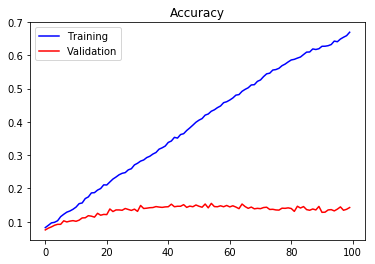

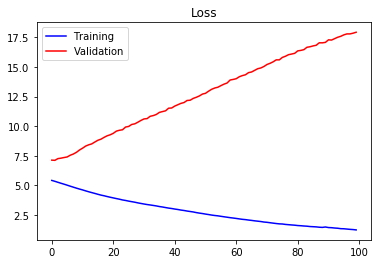

In [78]:
acc = history.history['accuracy']
loss = history.history['loss']

vacc = history.history['val_accuracy']
vloss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, 'b', label='Training')
plt.plot(epochs, vacc, 'r', label='Validation')
plt.title('Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training ')
plt.plot(epochs, vloss, 'r', label='Validation')
plt.title('Loss')
plt.legend()

plt.show()

<font color='magenta'> The network is clearly overfitting! You may want to train it on a cluster with a larger corpus of text. 

# 8. Sampling
Now the model is trained and you would like to generate new sentences. The process of generation is implemented below:

In [261]:
## Sampling a sentence!
seed_txt = 'the defendant appeal'

for ii in range(maxLen) :
    seed_seq = tokenizer.texts_to_sequences([seed_txt])[0]
    padded_seed = np.array(pad_sequences([seed_seq], maxlen=maxLen-1, padding=padding_type))
    pred = CL_model.predict_classes(padded_seed, verbose=0)
    seed_txt += ' ' + idx2word[pred[0]]

print(seed_txt)

the defendant appeal on the ground of meetings of appeals stated inevitable discretion v the improvement absurd results
